# En este notebook se entrena la red neuronal para resolver la ecuación del calor estocástica en 1D
___

## Importar librerías

In [32]:
import sys

sys.path.append("src")
from src.NeuralNetwork import NeuralNetwork
import numpy as np
import pickle as pkl
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [33]:
from google.colab import drive

drive.mount("/content/drive")
main_path = "/content/drive/MyDrive/SB/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


___

## Importar el Alpha Set

In [34]:
# Editar el nombre del archivo de datos si es particular
filename = "files/alpha_set_I1_J50_K2_n100_T0.25.pkl"
if not os.path.exists(filename):
    print(f"Primero se tiene que crear el archivo '{filename}'")
else:
    alpha_set = pkl.load(open(filename, "rb"))

___

## Crear dominio, función de pérdida y condición inicial

In [35]:
# Definir el dominio sobre el cual se va a trabajar
np.random.seed(97)
space_domain = np.random.normal(size=(1, 100))[0]

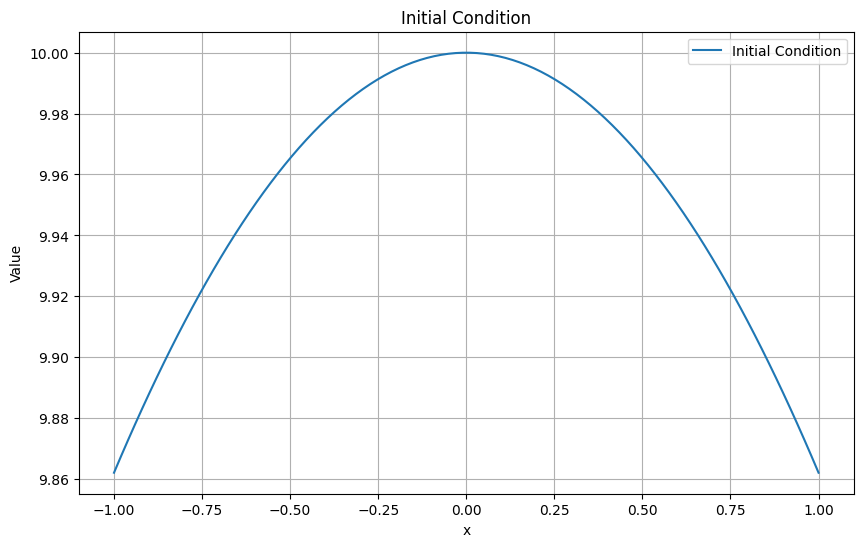

In [36]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return 10 * torch.exp(-x**2 / 72)


# Visualizar la condición inicial
plt.figure(figsize=(10, 6))
x = torch.linspace(-1, 1, 100).reshape(-1, 1)
y = initial_condition(x)
plt.plot(x, y, label="Initial Condition")
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

In [37]:
def loss_function(model, space_domain, initial_condition):
    """
    Función de pérdida para entrenar la red neuronal en el contexto de una SPDE.
    Esta función calcula la pérdida basada en la ecuación estocástica parcial diferencial (SPDE)
    para la ecuación del calor con ruido aditivo.

    Args:
        model (NeuralNetwork): La red neuronal que se está entrenando.
        space_domain (torch.Tensor): El dominio del espacio donde se evalúa la solución.
        initial_condition (function): La función que define la condición inicial del problema.

    Returns:
        torch.Tensor: El valor de la función de pérdida, que es la norma cuadrática del residuo de la SPDE.
    """
    # Detectar el dispositivo disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Poner el modelo en modo evaluación y mover al dispositivo
    model.eval()
    model.to(device)

    # ---------------------------------------------------------
    # Preparación: malla temporal y espacial
    # ---------------------------------------------------------
    t_interval = model.t
    t = torch.tensor(t_interval, dtype=torch.float32, device=device)

    dt = torch.tensor([t[1]], device=device)
    n = len(t)
    m = torch.tensor(range(1, n + 1), device=device)

    x = torch.tensor(space_domain, dtype=torch.float32, device=device)

    # Producto cartesiano
    Omega_t = torch.cartesian_prod(t, x).to(device).requires_grad_()
    Omega_dt = torch.cartesian_prod(dt, x).to(device).requires_grad_()

    # ---------------------------------------------------------
    # Evaluación de la red
    # ---------------------------------------------------------
    U_t = model(Omega_t)
    U_dt = model(Omega_dt)

    # Derivadas espaciales
    Ux_dt = torch.autograd.grad(
        U_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(U_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_x X

    Uxx_dt = torch.autograd.grad(
        Ux_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(Ux_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_{xx} X

    AX_term = torch.kron(m, Uxx_dt)

    # Ruido aditivo (incrementos de Brown)
    brownian_paths = (model.alpha_set.brownian_paths[model.omega])[0]
    paths_tensor = torch.tensor(brownian_paths, dtype=U_t.dtype, device=device)
    paths_tensor = paths_tensor.unsqueeze(1).repeat(1, len(space_domain)).reshape(-1)

    # Condición inicial
    initial_sol = initial_condition(x)
    initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)
    initial_sol_tensor_expanded = initial_sol_tensor.repeat(n)

    # Residuo
    residual = U_t - initial_sol_tensor_expanded - AX_term - paths_tensor

    # Función de pérdida
    return nn.MSELoss()(residual, torch.zeros_like(U_t))

___

## Entrenar la red neuronal

In [39]:
n_layers = 2  # Número de capas ocultas
wide = 128  # Ancho de las capas ocultas
activation = nn.Tanh  # Función de activación
epochs = 500  # Número de épocas de entrenamiento
optimizer = optim.Adam  # Optimizador
lr = 0.0005  # Tasa de aprendizaje

In [40]:
train = True  # True para entrenar la red, False para cargar un modelo preentrenado

In [ ]:
if train:
    # Definir modelo
    nn_model = NeuralNetwork(
        space_dim=1,
        alpha_set=alpha_set,
        n_layers=n_layers,
        wide=wide,
        activation=activation,
    )

    # Entrenar el modelo
    loss_list = nn_model.train_model(
        space_domain=space_domain,
        loss_function=loss_function,
        initial_condition=initial_condition,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        model_name="heat_1d_paper_01",
    )

    # Visualizar la pérdida durante el entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

    # Guardar el modelo entrenado
    torch.save(nn_model.state_dict(), main_path + "heat_1d_paper_01.txt")

/tmp/ipython-input-37-3715883126.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(space_domain, dtype=torch.float32, device=device)
/tmp/ipython-input-37-3715883126.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)


Epoch 0, Loss: 11040.5298, Best Loss: 11040.5298
Epoch 10, Loss: 54485.2503, Best Loss: 11040.5298
Epoch 20, Loss: 246.8648, Best Loss: 246.8648
Epoch 30, Loss: 20.8973, Best Loss: 20.2516


In [ ]:
if not train:
    # Cargar el modelo preentrenado
    if not os.path.exists("files/heat_1d_paper_01.txt"):
        print("Primero se tiene que crear el archivo 'files/heat_1d_paper_01.pkl'")
    else:
        nn_model = NeuralNetwork(
            space_dim=1,
            alpha_set=alpha_set,
            n_layers=n_layers,
            wide=wide,
            activation=activation,
        )
        nn_model.load_state_dict(torch.load(main_path + "heat_1d_paper_01.txt"))
        nn_model.eval()
        print("Modelo cargado")

___

## Evaluar el modelo

In [ ]:
# Selección el omega para evaluar la red neuronal
nn_model.omega = 0

# Crear la grilla de puntos (t, x) para evaluar la red neuronal
t_points = np.linspace(0, 0.25, 100)
x_points = np.linspace(-4, 4, 100)
t_grid, x_grid = np.meshgrid(t_points, x_points)
input_tensor = torch.tensor(
    np.stack([t_grid.ravel(), x_grid.ravel()], axis=1), dtype=torch.float32
)

# Calcular la salida de    # dt = dt.repeat(n)  # vector (Δt,…,Δt) la red neuronal
with torch.no_grad():
    output = nn_model(input_tensor).cpu().numpy().reshape(t_grid.shape)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(t_grid, x_grid, output, cmap="viridis")
fig.colorbar(surf)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("NN output")
ax.set_title("Modelo NN sobre el intervalo (t, x) en 3D")
plt.show()

___